In [70]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

import warnings
warnings.filterwarnings('error')

In [2]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)
with open('save/plt_agl_est','rb') as f:
    plt_agl_est = pickle.load(f)
with open('save/plt_ag', 'rb') as f:
    plt_ag = pickle.load(f)
with open('save/plt_agl', 'rb') as f:
    plt_agl = pickle.load(f)
with open('save/plt_ag_sw', 'rb') as f:
    plt_ag_sw = pickle.load(f)
with open('save/plt_agl_est_sw', 'rb') as f:
    plt_agl_est_sw = pickle.load(f)
with open('save/plt_agl_sw', 'rb') as f:
    plt_agl_sw = pickle.load(f)
with open('save/plt_ucbl_est', 'rb') as f:
    plt_ucbl_est = pickle.load(f)
with open('save/plt_ucb', 'rb') as f:
    plt_ucb = pickle.load(f)
with open('save/plt_ucb_vanilla', 'rb') as f:
    plt_ucb_vanilla = pickle.load(f)

In [5]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])
records.index = range(len(records))

In [3]:
with open('/home/home1/wy47/Regulating-Greed-Over-Time/save/records', 'rb') as f:
    records = pickle.load(f)

In [4]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [8]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]
with open('save/lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [19]:
records.clicked.value_counts()

0    26749863
1     1027832
Name: clicked, dtype: int64

In [7]:
unborn[0]

'id-615546'

In [8]:
pool[unborn[0]], pool[unborn[-1]]

(-1.0000 0/0 lifespan: (1318807500, 1318809293, None, None),
 -1.0000 0/0 lifespan: (1317513291, 1317616199, None, None))

In [9]:
pool['id-552077']

-1.0000 0/0 lifespan: (1317513291, 1317515399, None, None)

In [15]:
len(pool)

652

In [10]:
class AG_L:
    def __init__(self, records, lifespans, est_life=False):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        pool = {}
        for k in lifespans:
            pool[k] = Arm(lifespans[k])
        unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly
        self.best = None
        
    def update(self, record):
        self.rewards += record.clicked
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T
        if not self.best: # first record
            self.best = record.id
        else:
            if record.timestamp != self.prev_time:
                self.best = max(self.alive, key=lambda arm:self.pool[arm].X)
        self.prev_time = record.timestamp
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        # bisect module in Python doesn't support keys
        # implement my own bisect function that use .death as key
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to 'alive'
        # keep popping from 'unborn' until every born arm goes to 'alive'
        # arms in 'unborn' are sorted by birth in descending order
        # so the youngest arm is at the end of array
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            # insert this arm to correct position in 'alive'(sorted by death)
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
            
        
    def initialize(self, m):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = True
                else: #explore
                    if self.est_life: # if using life estimation(instead of knowing exact life span)
                        # filter by birth time
                        ranking = sorted(self.alive, key=lambda arm:self.pool[arm].birth, reverse=True)
                        pick = random.choice(ranking[:int(threshold*len(ranking))])
                    else:
                        pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = False
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [150]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
        self.ucb = float('inf')
        self.ucbl = float('inf')
    def __repr__(self):
        return '{:.4f} {}/{} {} lifespan: {}'.format(self.X, self.rewards, self.T, self.ucb, (self.birth, self.death, self.s, self.l))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly

In [161]:
class UCB_L:
    def __init__(self, records, lifespans=lifespans):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = {}
        for k in lifespans:
            self.pool[k] = Arm(lifespans[k])
        self.unborn = list(sorted(self.pool.keys(), key=lambda k:self.pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly
        self.avg_life = 1000000000
        self.X = 0        
        
    def update(self, record):
        self.rewards += record.clicked
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T
        if self.avg_life + arm.s - self.t + 1 <=0:
            psi = 0
        else:
            psi = .011 * np.log(self.avg_life + arm.s - self.t + 1)
    
        arm.ucbl = arm.X + psi * np.sqrt(2*np.log(self.t-arm.s+1)/arm.T)
        arm.ucb = arm.X + np.sqrt( 2*np.log(self.t)/arm.T )
        
    def filter_live(self):
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            self.pool[arm].s = self.t
            death = self.pool[arm].death
            heapq.heappush(self.alive, (death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)
                dying = self.pool[arm]
                dying.l = self.t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead
            else:
                break
                
    def initialize(self, m):
        self.m = m
        self.t = 1
        while self.t < self.m:
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                self.t += 1
    
    def play(self, n, mode='l'):
        for self.t in range(self.m, n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                if mode=='l':
                    pick = max(self.alive, key=lambda t:self.pool[t[1]].ucbl)[1] # choose alive arm with best ucbl
                else:
                    pick = max(self.alive, key=lambda t:self.pool[t[1]].ucb)[1] # choose alive arm with best ucb
                if pick == record.id:
                    self.update(record)
                    break

In [72]:
G = records.timestamp.value_counts()

In [74]:
G.describe()

count    1.194407e+06
mean     2.325647e+01
std      1.042916e+01
min      1.000000e+00
25%      1.500000e+01
50%      2.400000e+01
75%      3.100000e+01
max      6.700000e+01
Name: timestamp, dtype: float64

In [81]:
scores

{'id-552077': 45092, 'id-555224': 464613}

In [83]:
scores = {}
for arm in lifespans:
    scores[arm] = 0
    start, end = lifespans[arm]
    for i in range(start, end+1):
        try:
            scores[arm] += G[i]
        except KeyError as ke:
            continue

In [85]:
with open('save/scores','wb') as f:
    pickle.dump(scores, f)

In [130]:
class G_mortal:
    def __init__(self, records,G=G, lifespans=lifespans, scores=scores):
        self.records = records.itertuples()
        self.G = G
        self.scores = scores
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = {}
        for k in lifespans:
            self.pool[k] = Arm(lifespans[k])
        self.unborn = list(sorted(self.pool.keys(), key=lambda k:self.pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly
        self.X = 0        
        
    def update(self, record):
        self.rewards += record.clicked
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T
        epsilon = (1 + (self.t - arm.s)/self.G[record.timestamp])
        psi = .25 / len(self.alive) * len(list(filter(lambda death_arm:self.scores[death_arm[1]]<=self.scores[record.id], self.alive)))
        #print(arm.X, psi * np.sqrt(2*np.log(epsilon)/arm.T), epsilon, psi)
        arm.ucb = arm.X + psi * np.sqrt(2*np.log(epsilon)/arm.T)
        
    def filter_live(self):
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            self.pool[arm].s = self.t
            death = self.pool[arm].death
            heapq.heappush(self.alive, (death, arm))
        # pop dead arms from alive
        while self.alive[0][0] < self.time:
            heapq.heappop(self.alive)
                
    def initialize(self, m):
        self.m = m
        self.t = 1
        while self.t <= self.m:
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                self.t += 1
    
    def play(self, n):
        for self.t in range(self.m+1, n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                pick = max(self.alive, key=lambda t:self.pool[t[1]].ucb)[1] # choose alive arm with best ucb
                if pick == record.id:
                    self.update(record)
                    break

In [131]:
gm = G_mortal(records)
gm.initialize(25)
gm.play(100000)
gm.rewards

6129

In [63]:
next(gm.records)

Pandas(Index=2471791, timestamp=1317646939, id='id-566631', clicked=0)

In [162]:
def player(i):
    print('player',i,'started')
    ucb = UCB_L(records[i*10000:])
    ucb.initialize(25)
    ucb.play(100000,mode='n')
    return ucb.rewards
with Pool(30) as p:
    plt_ucb = p.map(player, [i for i in range(100)])

player 0 started
player 1 started
player 3 started
player 2 started
player 4 started
player 8 started
player 5 started
player 6 started
player 11 started
player 10 started
player 7 started
player 9 started
player 13 started
player 12 started
player 19 started
player 15 started
player 17 started
player 23 started
player 16 started
player 14 started
player 18 started
player 26 started
player 20 started
player 22 started
player 21 started
player 29 started
player 24 started
player 25 started
player 28 started
player 27 started
player 30 started
player 31 started
player 32 started
player 33 started
player 34 started
player 35 started
player 36 started
player 37 started
player 38 started
player 39 started
player 40 started
player 41 started
player 42 started
player 43 started
player 44 started
player 45 started
player 46 started
player 47 started
player 48 started
player 49 started
player 50 started
player 51 started
player 52 started
player 53 started
player 54 started
player 55 started
pl

In [143]:
def player(i):
    print('player',i,'started')
    ucbl = UCB_L(records[i*10000:])
    ucbl.initialize(25)
    ucbl.play(100000)
    return ucbl.rewards
with Pool(30) as p:
    plt_ucbl = p.map(player, [i for i in range(100)])

player 2 started
player 1 started
player 3 started
player 4 started
player 13 started
player 9 started
player 0 started
player 5 started
player 7 started
player 6 started
player 8 started
player 10 started
player 11 started
player 12 started
player 14 started
player 20 started
player 16 started
player 15 started
player 17 started
player 23 started
player 25 started
player 18 started
player 19 started
player 22 started
player 21 started
player 26 started
player 24 started
player 29 started
player 28 started
player 27 started
player 30 started
player 31 started
player 32 started
player 33 started
player 34 started
player 35 started
player 36 started
player 37 started
player 38 started
player 39 started
player 40 started
player 41 started
player 42 started
player 43 started
player 44 started
player 45 started
player 46 started
player 47 started
player 48 started
player 49 started
player 50 started
player 51 started
player 52 started
player 53 started
player 54 started
player 55 started
pl

In [132]:
def player(i):
    print('player',i,'started')
    gm = G_mortal(records[i*10000:])
    gm.initialize(25)
    gm.play(100000)
    return gm.rewards
with Pool(30) as p:
    plt_gm = p.map(player, [i for i in range(100)])

player 2 started
player 1 started
player 0 started
player 4 started
player 5 started
player 7 started
player 3 started
player 10 started
player 8 started
player 21 started
player 16 started
player 12 started
player 25 started
player 20 started
player 27 started
player 22 started
player 29 started
player 13 started
player 28 started
player 26 started
player 24 started
player 17 started
player 11 started
player 18 started
player 9 started
player 15 started
player 19 started
player 6 started
player 23 started
player 14 started
player 30 started
player 31 started
player 32 started
player 33 started
player 34 started
player 35 started
player 36 started
player 37 started
player 38 started
player 39 started
player 40 started
player 41 started
player 42 started
player 43 started
player 44 started
player 45 started
player 46 started
player 47 started
player 48 started
player 49 started
player 50 started
player 51 started
player 52 started
player 53 started
player 54 started
player 55 started
pl

In [66]:
with open('save/plt_gm','wb') as f:
    pickle.dump(plt_gm, f)

In [23]:
with open('save/plt_ucb','wb') as f:
    pickle.dump(plt_ucb, f)

In [25]:
# vanilla UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, 'vanilla')
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start, 'records:', next(ucbl.records).Index-1-i*10000, 'X',ucbl.X, 'avg_life', ucbl.avg_life)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucb_vanilla = p.map(player, [i for i in range(100)])

player 10 started
player 5 started
player 0 started
player 15 started
player 20 started
player 25 started
player: 0 reward: 5076 time: 311.2959213256836 records: 2535296 X 0.04991573113058068 avg_life 40766.35294117647
player 1 started
player: 5 reward: 4999 time: 437.28254103660583 records: 2810906 X 0.01347734389011819 avg_life 35922.083333333336
player 6 started
player: 15 reward: 4984 time: 480.4230329990387 records: 2757491 X 0.11438652461818206 avg_life 37157.256410256414
player 16 started
player: 10 reward: 4990 time: 509.63196849823 records: 2759633 X 0.02247262441272507 avg_life 35917.444444444445
player 11 started
player: 25 reward: 5258 time: 545.9158127307892 records: 3549190 X 0.04947553235511272 avg_life 34492.54716981131
player 26 started
player: 20 reward: 5224 time: 644.9697017669678 records: 3594576 X 0.06535114539896404 avg_life 34603.32075471698
player 21 started
player: 1 reward: 5079 time: 434.95812344551086 records: 2524517 X 0.08161442618610087 avg_life 40692.26

player 67 started
player: 80 reward: 5184 time: 614.8496854305267 records: 3242308 X 0.02285652638915882 avg_life 33465.82142857143
player 81 started
player: 62 reward: 5226 time: 719.2384080886841 records: 3364395 X 0.04155221579629958 avg_life 33245.62962962963
player 63 started
player: 85 reward: 5274 time: 536.1605558395386 records: 3187123 X 0.042924463317194794 avg_life 33559.89285714286
player 86 started
player: 71 reward: 5119 time: 611.7177546024323 records: 3319350 X 0.02898920056143059 avg_life 33632.857142857145
player 72 started
player: 76 reward: 5169 time: 676.100804567337 records: 3288553 X 0.043231339672520415 avg_life 33456.37499999999
player 77 started
player: 86 reward: 5088 time: 547.6951625347137 records: 3284922 X 0.05410295534576298 avg_life 33169.40350877193
player 87 started
player: 63 reward: 5163 time: 596.5061302185059 records: 3351227 X 0.06862766926648071 avg_life 33286.833333333336
player 64 started
player: 67 reward: 5203 time: 715.3436598777771 records

In [26]:
with open('save/plt_ucb_vanilla', 'wb') as f:
    pickle.dump(plt_ucb_vanilla, f)

In [21]:
with open('save/plt_ucbl_est', 'wb') as f:
    pickle.dump(plt_ucbl_est,f)

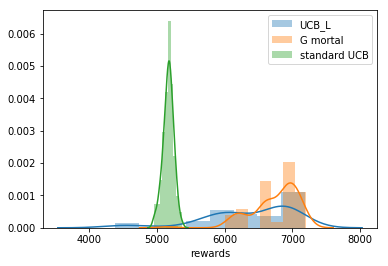

In [163]:
sns.distplot(plt_ucbl, label='UCB_L')
sns.distplot(plt_gm, label='G mortal')
sns.distplot(plt_ucb, label='standard UCB')

plt.legend()
plt.xlabel('rewards')
pass

In [156]:
ttest_ind(plt_ucbl, plt_gm)

Ttest_indResult(statistic=-5.1522098260448255, pvalue=6.202466293834907e-07)